Develop learning_wrapper algorithm

Utilize the combinations of UserBatch (class) and learning_dist_metrics

[pseudocode active weighting vector learning algorithm]
*step 1*: compute the aggregate distance information with argument of weighting vector [w]:
        a. sum of weighted distances of friends
        b. sum of weighted distances of non-friends
                               
*step 2*: argmin( [w] ) = sum(distances of same class) / sum(distances of different classes)
 
*step 3*: test hypothesis that location difference between friend-distance distribution
        vs. non-friend distance per user
                               
*step 4*: group users based on the previous test (paramer: distribution type, compared non-friend sample size):
        a. a user is assigned to group 1, if its two-type distance distributions location
           are significantly different;
        b. a user is assigned to group 2, if its two-type distance distributions location
           are not significantly different.
               
*step 5*: apply the 1-4 steps on users of group 1, split users of this group into: group 1 (with siganificant
        difference) and group 3 (with insignificant difference);
        Similiarly, apply 1-4 steps on users of group 2, split users of this group into: group 2 (with significant
        difference) and group 3 (with insignificant diference).
 
*step 6*: repeat 5th step until the stoping threshold is met:
        a. fixed iteration, or;
        b. insubstantial change in either weighting vector, or;
        c. insubstantial change in members in group 1-3.

In [45]:
import os
import sys
import glob
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

from scipy.stats import rayleigh
from scipy.stats import ks_2samp
from numpy import linspace
from numpy.random import choice
from networkx import Graph

from learning_dist_metrics.ldm import LDM
from learning_dist_metrics.dist_metrics import weighted_euclidean

import matplotlib.pyplot as plt
%matplotlib inline

load the simulate data sets, the frienships were generated based on "hand-shaking" protocol.

In [3]:
DATA_PATH = "./data/sim_data_yi/" 

users_df   = pd.read_csv(DATA_PATH + "users_profile.csv", header = 0, sep = ",")
friends_df = pd.read_csv(DATA_PATH + "friendships.csv", header = 0, sep = ",")
dist_df    = pd.read_csv(DATA_PATH + "dist_mat.csv", header = 0, sep = ",")

In [4]:
## friends_df is processed
## a. create a new column to denote the user pair
## b. exclude user-pair of non-friends
## c. drop the 'isFriend' columns
friends_df = friends_df[friends_df.isFriend == 1]
friends_df["pair"] = friends_df[["uid_a", "uid_b"]].apply(lambda x: (int(x[0]), int(x[1])), axis=1)
friends_df.drop("isFriend", axis=1, inplace=True)
friends_df = friends_df[["pair", "uid_a", "uid_b"]]
friends_df.head(3)

,pair,uid_a,uid_b
1,"(0, 2)",0,2
3,"(0, 4)",0,4
4,"(0, 5)",0,5


In [24]:
cols = ["x0", "x1", "x2", "x3", "x4", "x5"]

## subset users data to retain profile only
profile_df = users_df[["ID"] + cols]
all_user_ids = list(set(users_df.ID))

ldm = LDM()
ldm.fit(profile_df, friends_df.pair.as_matrix())
the_weights = ldm.get_transform_matrix()
print the_weights

--- 327.048465967 seconds ---


#### learning wrapper functions
* user_grouped_dist()
* user_dist_kstest()
* users_filter_by_weights()
* ldm_train_with_list

In [ ]:
def user_grouped_dist(user_id, weights, profile_df, friends_df):
    """ Calculate distances between a user and whose friends
        and distance between a user and whose non-friends.
        The groupped distance vector will be output.

        Parameters:
        ----------
        * user_id: {integer}, the target user's ID
        * weights: {vector-like, float}, the vector of feature weights which
            is extracted by LDM().fit(x, y).get_transform_matrix()
        * profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
            with columns: ["ID", "x0" - "xn"]
        * friends_df: {matrix-like, pandas.DataFrame}, pandas.DataFrame store
            pair of user ID(s) to represent connections with columns:
            ["uid_a", "uid_b"]

        Returns:
        -------
        res: {list, list of integers}, a list of two lists, which store the distances
            of either friends and non-friends separately.

        Examples:
        ---------
        weights = ldm().fit(df, friends_list).get_transform_matrix()
        profile_df = users_df[ ["ID"] + cols ]
        user_dist = user_grouped_dist(user_id = 0, weights = weights
            , profile_df, friends_df)
        print user_dist["friends"]
        print user_dist["nonfriends"]
    """
    cols = [col for col in profile_df.columns if col is not "ID"]
    # get the user profile information of the target users
    user_profile = profile_df.ix[profile_df.ID == user_id, cols].as_matrix()
    # get the user_id of friends of the target user
    friends_ls_a = friends_df[friends_df.uid_a == user_id].uid_b.as_matrix()
    friends_ls_b = friends_df[friends_df.uid_b == user_id].uid_a.as_matrix()
    friends_ls = list(set(friends_ls_a)) + list(set(friends_ls_b))
    # calculate the weighted distance of friends
    sim_dist_vec = []
    for f_id in friends_ls:
        friend_profile = profile_df.ix[profile_df.ID == f_id, cols].as_matrix()
        the_dist = weighted_euclidean(user_profile, friend_profile, weights)
        sim_dist_vec.append(the_dist)
    # calculate the weighted distances of non-friends
    non_friends_ls = [ u for u in profile_df.ID if u not in friends_ls + [user_id] ]
    diff_dist_vec = []
    for nf_id in non_friends_ls:
        nonfriend_profile = profile_df.ix[profile_df.ID == nf_id, cols].as_matrix()
        the_dist = weighted_euclidean(user_profile, nonfriend_profile, weights)
        diff_dist_vec.append(the_dist)

    res = [sim_dist_vec, diff_dist_vec]
    return res


def user_dist_kstest(sim_dist_vec, diff_dist_vec):
    """ Test the goodness of a given weights to defferentiate friend distance
        distributions and non-friend distance distributions of a given user.
        The distance distribution is considered to follow Rayleigh distribution.

        Parameters:
        ----------
        * sim_dist_vec: {vector-like (list), float}: distances between friends
            and the user
        * diff_dist_vec: {vector-like (list), float}: distances between non-friends
            and the user

        Returns:
        -------
        * res: {float}: p-value of ks-test with assumption that distances follow
            Rayleigh distribution.

        Examples:
        ---------
        pval = user_dist_kstest(sim_dist_vec, diff_dist_vec)
    """
    _n = 100
    friend_param = rayleigh.fit(sim_dist_vec)
    nonfriend_param = rayleigh.fit(diff_dist_vec)

    samp_friend = rayleigh.rvs(friend_param[0], friend_param[1], _n)
    samp_nonfriend = rayleigh.rvs(nonfriend_param[0], nonfriend_param[1], _n)

    ## ouput p-value of ks-test
    res = ks_2samp(samp_friend, samp_nonfriend)[1]
    return res


def users_filter_by_weights(weights, profile_df, friends_df,
                            pval_threshold=0.20, min_friend_cnt=10):
    """ Split a list of users into two groups, "good fit group"(reject) and
        "invalid group", with respect to the ks-test on the null hypothesis
        that friends' weighted distance is not significantly different from the
        couterpart of non-friends. Assume the weighted distances of each group
        follow Rayleigh distribution.

        Parameters:
        ----------
        * weights: {vector-like, float}, the vector of feature weights which
            is extracted by LDM().fit(x, y).get_transform_matrix()
        * profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
            with columns: ["ID", "x0" - "xn"]
        * friends_df: {matrix-like, pandas.DataFrame}, pandas.DataFrame store
            pair of user ID(s) to represent connections with columns:
            ["uid_a", "uid_b"]
        * pval_threshold: {float}, the threshold for p-value to reject hypothesis
        * min_friend_cnt: {integer}, drop users whose total of friends is less
            than this minimum count

        Returns:
        -------
        res: {list} grouped list of user ids
           res[0] stores all users whose null hypothesis does not holds
           res[1] stores all users whose null hypothesis hold
           null hypothesis, given weights, distance distribution of all friends
           is significantly different from distance distribution of all non-fri
           -ends

        Examples:
        --------
        weights = ldm().fit(df, friends_list).get_transform_matrix()
        profile_df = users_df[["ID", cols]]
        grouped_users = users_filter_by_weights(weights,
                            profile_df, friends_df,
                            pval_threshold = 0.10, min_friend_cnt = 10)

        Notes:
        -----
        min_friend_cnt is not implemented
    """

    all_users_ids = list(set(profile_df.ID))
    # container for users meeting different critiria
    good_fits = []
    bad_fits = []
    for uid in all_users_ids:
        res_dists = user_grouped_dist(uid, weights, profile_df, friends_df)
        pval = user_dist_kstest(res_dists[0], res_dists[1])
        if pval <= pval_threshold:
            good_fits.append(uid)
        else:
            bad_fits.append(uid)

    res = [good_fits, bad_fits]
    return res

def user_grouped_dist(user_id, weights, profile_df, friends_df):
    """ Calculate distances between a user and whose friends
        and distance between a user and whose non-friends.
        The groupped distance vector will be output.

        Parameters:
        ----------
        * user_id: {integer}, the target user's ID
        * weights: {vector-like, float}, the vector of feature weights which
            is extracted by LDM().fit(x, y).get_transform_matrix()
        * profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
            with columns: ["ID", "x0" - "xn"]
        * friends_df: {matrix-like, pandas.DataFrame}, pandas.DataFrame store
            pair of user ID(s) to represent connections with columns:
            ["uid_a", "uid_b"]

        Returns:
        -------
        res: {list, list of integers}, a list of two lists, which store the distances
            of either friends and non-friends separately.

        Examples:
        ---------
        weights = ldm().fit(df, friends_list).get_transform_matrix()
        profile_df = users_df[ ["ID"] + cols ]
        user_dist = user_grouped_dist(user_id = 0, weights = weights
            , profile_df, friends_df)
        print user_dist["friends"]
        print user_dist["nonfriends"]
    """
    cols = [col for col in profile_df.columns if col is not "ID"]
    # get the user profile information of the target users
    user_profile = profile_df.ix[profile_df.ID == user_id, cols].as_matrix()
    # get the user_id of friends of the target user
    friends_ls_a = friends_df[friends_df.uid_a == user_id].uid_b.as_matrix()
    friends_ls_b = friends_df[friends_df.uid_b == user_id].uid_a.as_matrix()
    friends_ls = list(set(friends_ls_a)) + list(set(friends_ls_b))
    # calculate the weighted distance of friends
    sim_dist_vec = []
    for f_id in friends_ls:
        friend_profile = profile_df.ix[profile_df.ID == f_id, cols].as_matrix()
        the_dist = weighted_euclidean(user_profile, friend_profile, weights)
        sim_dist_vec.append(the_dist)
    # calculate the weighted distances of non-friends
    non_friends_ls = [u for u in profile_df.ID if u not in friends_ls + [user_id] ]
    diff_dist_vec = []
    for nf_id in non_friends_ls:
        nonfriend_profile = profile_df.ix[profile_df.ID == nf_id, cols].as_matrix()
        the_dist = weighted_euclidean(user_profile, nonfriend_profile, weights)
        diff_dist_vec.append(the_dist)

    res = [sim_dist_vec, diff_dist_vec]
    return res


def user_dist_kstest(sim_dist_vec, diff_dist_vec,
                     fit_rayleigh=True, min_nobs=10, _n=100):
    """ Test the goodness of a given weights to defferentiate friend distance
        distributions and non-friend distance distributions of a given user.
        The distance distribution is considered to follow Rayleigh distribution.

    Parameters:
    ----------
    sim_dist_vec: {vector-like (list), float}, distances between friends
                  and the user
    diff_dist_vec: {vector-like (list), float}, distances between non-fri
                   -ends and the user
    fit_rayleigh: {boolean}, determine if fit data into Rayleigth distri
                  -bution
    min_nobs: {integer}, minmum number of observations required for compar
              -ing
    _n: {integer}, number of random samples generated from estimated 
        distribution

    Returns:
    -------
    * res: {float}: p-value of ks-test with assumption that distances follow
            Rayleigh distribution.

    Examples:
    ---------
    pval = user_dist_kstest(sim_dist_vec, diff_dist_vec)
    """
    is_valid =  (len(sim_dist_vec) >= min_nobs) & \
                (len(diff_dist_vec) >= min_nobs) # not used yet
    if fit_rayleigh:
        friend_param = rayleigh.fit(sim_dist_vec)
        nonfriend_param = rayleigh.fit(diff_dist_vec)

        samp_friend = rayleigh.rvs(friend_param[0], friend_param[1], _n)
        samp_nonfriend = rayleigh.rvs(nonfriend_param[0], nonfriend_param[1],
                                      _n)

        ## ouput p-value of ks-test
        res = ks_2samp(samp_friend, samp_nonfriend)[1]
    else:
        res = ks_2samp(sim_dist_vec, diff_dist_vec)[1]
    return res


def users_filter_by_weights(weights, users_list, profile_df, friends_df,
                            pval_threshold=0.20,
                            mutate_rate=0.4,
                            min_friend_cnt=10):
    """ Split users into two groups, "keep" and "mutate", with respect to
        p-value of the ks-test on the null hypothesis that the distribution of
        friends' weighted distance is not significantly different from the
        couterpart for non-friends. Assume the weighted distances of each group
        follow Rayleigh distribution.

        Parameters:
        ----------
        * weights: {vector-like, float}, the vector of feature weights which
            is extracted by LDM().fit(x, y).get_transform_matrix()
        * users_list: {vector-like, integer}, the list of user id
        * profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
            with columns: ["ID", "x0" - "xn"]
        * friends_df: {matrix-like, pandas.DataFrame}, pandas.DataFrame store
            pair of user ID(s) to represent connections with columns:
            ["uid_a", "uid_b"]
        * pval_threshold: {float}, the threshold for p-value to reject hypothes
            -is
        * min_friend_cnt: {integer}, drop users whose total of friends is less
            than this minimum count
        * mutate_rate: {float}, a float value [0 - 1] determine the percentage
            of bad_fits member sent to mutation

        Returns:
        -------
        res: {list} grouped list of user ids
           res[0] stores all users whose null hypothesis does not holds
           res[1] stores all users whose null hypothesis hold
           null hypothesis, given weights, distance distribution of all friends
           is significantly different from distance distribution of all non-fri
           -ends

        Examples:
        --------
        weights = ldm().fit(df, friends_list).get_transform_matrix()
        profile_df = users_df[["ID"] + cols]
        grouped_users = users_filter_by_weights(weights,
                            profile_df, friends_df,
                            pval_threshold = 0.10, min_friend_cnt = 10)

        Notes:
        -----
        min_friend_cnt is not implemented
    """
    # all_users_ids = list(set(profile_df.ID))
    # users_list
    # container for users meeting different critiria
    pvals = []
    for uid in users_list:
        res_dists = user_grouped_dist(uid, weights, profile_df, friends_df)
        pvals.append(user_dist_kstest(res_dists[0], res_dists[1]))
    #    if pval <= pval_threshold:
    #        good_fits.append(uid)
    #    else:
    #        bad_fits.append(uid)
    sorted_id_pval = sorted(zip(users_list, pvals), key=lambda x: x[1])
    good_fits = [i for i, p in sorted_id_pval if p <= pval_threshold]
    bad_fits = [i for i, p in sorted_id_pval if p > pval_threshold]

    if len(bad_fits) > 0:
        mutate_size = max(len(bad_fits) * mutate_rate, 1)
        
    id_mutate = bad_fits[:mutate_size]
    id_retain = good_fits + bad_fits[mutate_size:]
    return [id_retain, id_mutate]


def ldm_train_with_list(users_list,
                        profile_df, friends_df,
                        retain_type=0):
    """ learning distance matrics with ldm() instance, provided
        with selected list of users.

        Parameters:
        -----------
        * users_list: {vector-like, integer}, the list of user id
        * profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
            with columns: ["ID", "x0" - "xn"]
        * friends_df: {matrix-like, pandas.DataFrame}, pandas.DataFrame store
            pair of user ID(s) to represent connections with columns:
            ["uid_a", "uid_b"]
        * retain_type: {integer}, 0, adopting 'or' logic by keeping relation
            -ship in friends_df if either of entities is in user_list
            1, adopting 'and' logic

        Returns:
        -------
        res: {vector-like, float}, output of ldm.get_transform_matrix()

        Examples:
        ---------
        new_dist_metrics = ldm_train_with_list(user_list,
                                               profile_df,
                                               friends_df)
    """
    ldm = LDM()
    if retain_type == 0:
        friends_df = friends_df.ix[friends_df.uid_a.isin(users_list) |
                                   friends_df.uid_b.isin(users_list)]
    else:
        friends_df = friends_df.ix[friends_df.uid_a.isin(users_list) &
                                   friends_df.uid_b.isin(users_list)]

    cols = profile_df.columns.drop("ID")
    ldm.fit(profile_df[cols], friends_df.pair.as_matrix())
    return ldm.get_transform_matrix()

In this section, I will simulate the iterative learning process by run the line in a manual fashion

In [37]:
ldm = LDM()
ldm.fit(profile_df, friends_df.pair.as_matrix())
the_weights = ldm.get_transform_matrix()

g0, g1 = users_filter_by_weights(the_weights, all_users_ids, profile_df, friends_df, 0.20, 10, 0.4)
print "# of memebers in group 0: %d, # of memebers in group 1: %d" % (len(g0), len(g1))

# of memebers in group 0: 25, # of memebers in group 1: 75


#### max_iteration, fixed pvalue = 0.20, retain_type = 0

In [40]:
# learning parameter
RETAIN_TYPE = 0
PVAL = 0.20
MIN_FRIENDS = 10 # not implemented in function
# hyper-parameter
max_iters = 10
mutate_rate = 0.2
# process controller
counter = 0

while counter < max_iters:
    counter += 1
    print "------- %d iteration --------" % counter
    g0_dist = ldm_train_with_list(g0, profile_df, friends_df, retain_type=RETAIN_TYPE)
    g1_dist = ldm_train_with_list(g1, profile_df, friends_df, retain_type=RETAIN_TYPE)
    print "Group 0's learned distance metrics:"
    print g0_dist
    print "Group 1's learned distance metrics:"
    print g1_dist

    print "---------------------------------------------- "
    g0_good, g0_bad = users_filter_by_weights(g0_dist, g0, profile_df, friends_df, PVAL, 10, mutate_rate)
    print "# of good fits: %d, # of bad fits: %d" % (len(g0_good), len(g0_bad))
    g1_good, g1_bad = users_filter_by_weights(g1_dist, g1, profile_df, friends_df, PVAL, 10, mutate_rate)
    print "# of good fits: %d, # of bad fits: %d" % (len(g1_good), len(g1_bad))

    print "---------------------------------------------- "
    g0 = g0_good + g1_bad
    g1 = g0_bad + g1_good
    print "# of memebers in group 0: %d, # of memebers in group 1: %d" % (len(g0), len(g1)) 
    print "*********************************************** \n"
    

------- 1 iteration --------
--- 36.869204998 seconds ---
--- 27.047164917 seconds ---
Group 0's learned distance metrics:
[0.48, 0.52, 0.0, 0.0, 0.0, 0.0]
Group 1's learned distance metrics:
[0.36, 0.62, 0.0, 0.02, 0.0, 0.0]
---------------------------------------------- 
# of good fits: 23, # of bad fits: 29
# of good fits: 23, # of bad fits: 25
---------------------------------------------- 
# of memebers in group 0: 48, # of memebers in group 1: 52
*********************************************** 

------- 2 iteration --------
--- 39.359773159 seconds ---
--- 35.5848631859 seconds ---
Group 0's learned distance metrics:
[0.42, 0.57, 0.0, 0.0, 0.0, 0.0]
Group 1's learned distance metrics:
[0.42, 0.58, 0.0, 0.01, 0.0, 0.0]
---------------------------------------------- 
# of good fits: 23, # of bad fits: 25
# of good fits: 26, # of bad fits: 26
---------------------------------------------- 
# of memebers in group 0: 49, # of memebers in group 1: 51
***********************************

#### max_iteration, fixed pvalue = 0.20, retain_type = 1

In [44]:
# learning parameter
RETAIN_TYPE = 0
PVAL = 0.50
MIN_FRIENDS = 10 # not implemented in function
# hyper-parameter
max_iters = 20
mutate_rate = 0.1
# process controller
counter = 0

# performance collector
num_good_fits = []
num_bad_fits = []
g0_dist_weights = []
g1_dist_weights = []
g0_size = []
g1_size = []


while counter < max_iters:
    counter += 1
    print "------- %d iteration --------" % counter
    g0_dist = ldm_train_with_list(g0, profile_df, friends_df, retain_type=RETAIN_TYPE)
    g1_dist = ldm_train_with_list(g1, profile_df, friends_df, retain_type=RETAIN_TYPE)
    print "Group 0's learned distance metrics:"
    print g0_dist
    print "Group 1's learned distance metrics:"
    print g1_dist

    print "---------------------------------------------- "
    g0_good, g0_bad = users_filter_by_weights(g0_dist, g0, profile_df, friends_df, PVAL, 10, mutate_rate)
    print "# of good fits: %d, # of bad fits: %d" % (len(g0_good), len(g0_bad))
    g1_good, g1_bad = users_filter_by_weights(g1_dist, g1, profile_df, friends_df, PVAL, 10, mutate_rate)
    print "# of good fits: %d, # of bad fits: %d" % (len(g1_good), len(g1_bad))

    print "---------------------------------------------- "
    g0 = g0_good + g1_bad
    g1 = g0_bad + g1_good
    print "# of memebers in group 0: %d, # of memebers in group 1: %d" % (len(g0), len(g1)) 
    print "*********************************************** \n"
    
    g0_dist_weights.append(g0_dist)
    g1_dist_weights.append(g1_dist)
    num_good_fits.append(len(g0_good) + len(g1_good))
    num_bad_fits.append(len(g0_bad) + len(g1_bad))
    g0_size.append(len(g0))
    g1_size.append(len(g1))

------- 1 iteration --------
--- 35.3054549694 seconds ---
--- 36.366134882 seconds ---
Group 0's learned distance metrics:
[0.41, 0.58, 0.0, 0.01, 0.0, 0.0]
Group 1's learned distance metrics:
[0.45, 0.55, 0.0, 0.0, 0.0, 0.0]
---------------------------------------------- 
# of good fits: 36, # of bad fits: 23
# of good fits: 28, # of bad fits: 13
---------------------------------------------- 
# of memebers in group 0: 49, # of memebers in group 1: 51
*********************************************** 

------- 2 iteration --------
--- 30.9826378822 seconds ---
--- 39.2912659645 seconds ---
Group 0's learned distance metrics:
[0.39, 0.6, 0.0, 0.02, 0.0, 0.0]
Group 1's learned distance metrics:
[0.47, 0.53, 0.0, 0.0, 0.0, 0.0]
---------------------------------------------- 
# of good fits: 34, # of bad fits: 15
# of good fits: 35, # of bad fits: 16
---------------------------------------------- 
# of memebers in group 0: 50, # of memebers in group 1: 50
**********************************

#### Utilize the 'networkx' module to store the relationship information
* Access the information via Graph() object

In [65]:
fnx = Graph()
fnx.add_nodes_from(list(set(users_df.ID)))

for a, b in friends_df.pair:
    fnx.add_edge(a, b)

(array([  2.,   6.,  10.,  11.,  11.,  16.,  14.,  10.,  11.,   9.]),
 array([ 33. ,  38.2,  43.4,  48.6,  53.8,  59. ,  64.2,  69.4,  74.6,
         79.8,  85. ]),
 <a list of 10 Patch objects>)

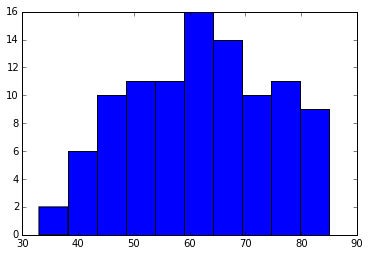

In [66]:
num_friends = [fnx.degree(u) for u in fnx]
plt.hist(num_friends)

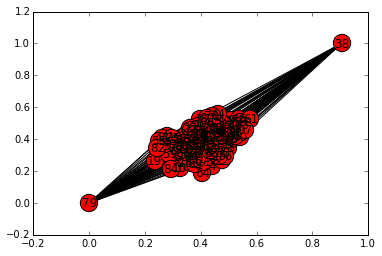

In [67]:
nx.draw_networkx(fnx)

In [70]:
user_id = 0
friends_ls = fnx.neighbors(0)
non_friends_ls = [u for u in profile_df.ID if u not in friends_ls + [user_id]]
print "# of friends: %d, # of non-friends: %d" % (len(friends_ls), len(non_friends_ls))

# of friends: 62, # of non-friends: 37


#### Test Against True Weight Distance
* w0: group 0 true distance weights
* w1: group 1 true distance weights

In [81]:
w0 = [0.5, 0.5, 0.1, 0, 0, 0]
w1 = [0, 0, 0, 0.5, 0.3, 0.2]
tg0_ids = users_df.ix[users_df.decision_style == 0, "ID"]
tg1_ids = users_df.ix[users_df.decision_style == 1, "ID"]

### Update functions

In [233]:
def user_grouped_dist(user_id, weights, profile_df, friends_networkx):
    """ Calculate distances between a user and whose friends
        and distance between a user and whose non-friends.
        The groupped distance vector will be output.

        Parameters:
        ----------
        * user_id: {integer}, the target user's ID
        * weights: {vector-like, float}, the vector of feature weights which
            is extracted by LDM().fit(x, y).get_transform_matrix()
        * profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
            with columns: ["ID", "x0" - "xn"]
        * friends_networkx: {networkx.Graph()}, Graph() object from Networkx
            to store the relationships information

        Returns:
        -------
        res: {list, list of integers}, a list of two lists, which store the distances
            of either friends and non-friends separately.

        Examples:
        ---------
        weights = ldm().fit(df, friends_list).get_transform_matrix()
        profile_df = users_df[ ["ID"] + cols ]
        user_dist = user_grouped_dist(user_id = 0, weights = weights
            , profile_df, friends_df)
        print user_dist["friends"]
        print user_dist["nonfriends"]
    """
    cols = [col for col in profile_df.columns if col is not "ID"]
    # get the user profile information of the target users
    user_profile = profile_df.ix[profile_df.ID == user_id, cols].as_matrix()
    # get the user_id of friends of the target user
    friends_ls = friends_networkx.neighbors(user_id)
    all_ids = profile_df.ID
    non_friends_ls = [u for u in all_ids if u not in friends_ls + [user_id]]

    sim_dist_vec = []
    for f_id in friends_ls:
        friend_profile = profile_df.ix[profile_df.ID == f_id, cols].as_matrix()
        the_dist = weighted_euclidean(user_profile, friend_profile, weights)
        sim_dist_vec.append(the_dist)

    diff_dist_vec = []
    for nf_id in non_friends_ls:
        nonfriend_profile = profile_df.ix[profile_df.ID == nf_id, cols].as_matrix()
        the_dist = weighted_euclidean(user_profile, nonfriend_profile, weights)
        diff_dist_vec.append(the_dist)

    res = [sim_dist_vec, diff_dist_vec]
    return res


def user_dist_kstest(sim_dist_vec, diff_dist_vec,
                     fit_rayleigh=False, _n=100):
    """ Test the goodness of a given weights to defferentiate friend distance
        distributions and non-friend distance distributions of a given user.
        The distance distribution is considered to follow Rayleigh distribution.

    Parameters:
    ----------
    sim_dist_vec: {vector-like (list), float}, distances between friends
                  and the user
    diff_dist_vec: {vector-like (list), float}, distances between non-fri
                   -ends and the user
    fit_rayleigh: {boolean}, determine if fit data into Rayleigth distri
                  -bution
    _n: {integer}, number of random samples generated from estimated
        distribution

    Returns:
    -------
    * res: {float}: p-value of ks-test with assumption that distances follow
            Rayleigh distribution.

    Examples:
    ---------
    pval = user_dist_kstest(sim_dist_vec, diff_dist_vec)
    """
    # is_valid = (len(sim_dist_vec) >= min_nobs) & \
    #           (len(diff_dist_vec) >= min_nobs) # not used yet
    if fit_rayleigh:
        friend_param = rayleigh.fit(sim_dist_vec)
        nonfriend_param = rayleigh.fit(diff_dist_vec)

        samp_friend = rayleigh.rvs(friend_param[0], friend_param[1], _n)
        samp_nonfriend = rayleigh.rvs(nonfriend_param[0], nonfriend_param[1],
                                      _n)

        # ouput p-value of ks-test
        res = ks_2samp(samp_friend, samp_nonfriend)[1]
    else:
        res = ks_2samp(sim_dist_vec, diff_dist_vec)[1]
    return res


def users_filter_by_weights(weights, profile_df, friends_networkx,
                            pval_threshold=0.5, 
                            mutate_rate=0.4,
                            min_friend_cnt=10, 
                            users_list=None,
                            fit_rayleigh=False, 
                            _n=1000):
    """ Split users into two groups, "keep" and "mutate", with respect to
        p-value of the ks-test on the null hypothesis that the distribution of
        friends' weighted distance is not significantly different from the
        couterpart for non-friends. Assume the weighted distances of each group
        follow Rayleigh distribution.

    Parameters:
    ----------
    weights: {vector-like, float}, the vector of feature weights which
        is extracted by LDM().fit(x, y).get_transform_matrix()
    users_list: {vector-like, integer}, the list of user id
    profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    friends_networkx: {networkx.Graph()}, Graph() object from Networkx to store
        the relationships information
    pval_threshold: {float}, the threshold for p-value to reject hypothesis
    min_friend_cnt: {integer}, drop users whose total of friends is less than
       this minimum count
    mutate_rate: {float}, a float value [0 - 1] determine the percentage of
       bad_fits member sent to mutation
    fit_rayleigh: {boolean}, determine if fit data into Rayleigth distri
                  -bution
    _n: {integer}, number of random samples generated from estimated
        distribution

    Returns:
    -------
    res: {list} grouped list of user ids
        res[0] stores all users whose null hypothesis does not holds;
        res[1] stores all users whose null hypothesis hold null hypothesis,
        given weights, distance distribution of all friends is significantly
        different from distance distribution of all non-friends

    Examples:
    --------
    weights = ldm().fit(df, friends_list).get_transform_matrix()
    profile_df = users_df[["ID"] + cols]
    grouped_users = users_filter_by_weights(weights,
                       profile_df, friends_df, pval_threshold = 0.10,
                       min_friend_cnt = 10)

    Notes:
    -----
    min_friend_cnt is not implemented
    """
    # all_users_ids = list(set(profile_df.ID))
    # users_list
    # container for users meeting different critiria
    pvals = []
    if users_list is None:
        users_list = list(profile_df.ix[:, 0])

    for uid in users_list:
        res_dists = user_grouped_dist(uid, weights, profile_df,
                                      friends_networkx=friends_networkx)
        pval = user_dist_kstest(res_dists[0], res_dists[1], fit_rayleigh, _n)
        pvals.append(pval)

    sorted_id_pval = sorted(zip(users_list, pvals), key=lambda x: x[1])
    good_fits = [i for i, p in sorted_id_pval if p < pval_threshold]
    bad_fits = [i for i, p in sorted_id_pval if p >= pval_threshold]

    if len(bad_fits) > 0:
        mutate_size = floor(len(bad_fits) * mutate_rate)
        mutate_size = max(int(mutate_size), 1)
        id_mutate = bad_fits[:mutate_size]
        id_retain = good_fits + bad_fits[mutate_size:]
    else:
        id_mutate = bad_fits
        id_retain = good_fits
        
    res = [id_retain, id_mutate]
    return res


def ldm_train_with_list(users_list, profile_df, friends_df, retain_type=0):
    """ learning distance matrics with ldm() instance, provided with selected
        list of users.

    Parameters:
    -----------
    users_list: {vector-like, integer}, the list of user id
    profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    friends_df: {matrix-like, pandas.DataFrame}, pandas.DataFrame store pair of
        user ID(s) to represent connections with columns: ["uid_a", "uid_b"]
    friends_networkx: {networkx.Graph()}, Graph() object from Networkx to store
        the relationships information
    retain_type: {integer}, 0, adopting 'or' logic by keeping relationship in
        friends_df if either of entities is in user_list 1, adopting 'and'
        logic

    Returns:
    -------
    res: {vector-like, float}, output of ldm.get_transform_matrix()

    Examples:
    ---------
    new_dist_metrics = ldm_train_with_list(user_list, profile_df, friends_df)
    """
    ldm = LDM()
    if retain_type == 0:
        friends_df = friends_df.ix[friends_df.uid_a.isin(users_list) |
                                   friends_df.uid_b.isin(users_list)]
    else:
        friends_df = friends_df.ix[friends_df.uid_a.isin(users_list) &
                                   friends_df.uid_b.isin(users_list)]

    cols = profile_df.columns.drop("ID")
    ldm.fit(profile_df[cols], friends_df.pair.as_matrix())
    return ldm.get_transform_matrix()

In [173]:
def hyper_parameter_tester(weights_a, weights_b, fit_rayleigh, num):
    
    num_friends = []
    num_nonfriends = []
    ks_pvals_right = []
    ks_pvals_wrong = []

    for uid in tg0_ids: 
        sim_dists, diff_dists = user_grouped_dist(uid, weights_a, profile_df, fnx)
        pval = user_dist_kstest(sim_dists, diff_dists, fit_rayleigh=fit_rayleigh, _n = num)
        ks_pvals_right.append(pval)
    
        sim_dists, diff_dists = user_grouped_dist(uid, weights_b, profile_df, fnx)
        pval = user_dist_kstest(sim_dists, diff_dists, fit_rayleigh=fit_rayleigh, _n = num)
        ks_pvals_wrong.append(pval)
    
        num_friends.append(len(sim_dists))
        num_nonfriends.append(len(diff_dists))
    
    res_report = pd.DataFrame({"ID": tg0_ids, "num_friends": num_friends, 
                              "num_nonfriends": num_nonfriends, 
                              "true_pval": ks_pvals_right,
                              "wrong_pval": ks_pvals_wrong})
    return res_report

### Test Rayleigh-based KS-test to detection power with varying #sample
* changing distance weights
* increasing number of n

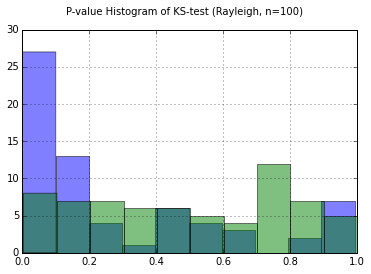

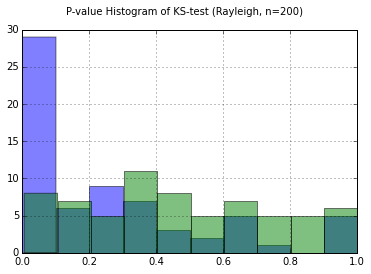

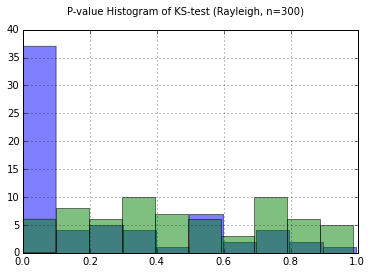

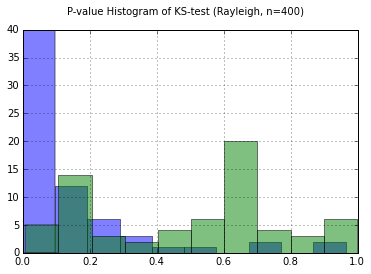

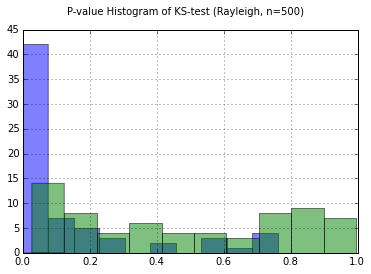

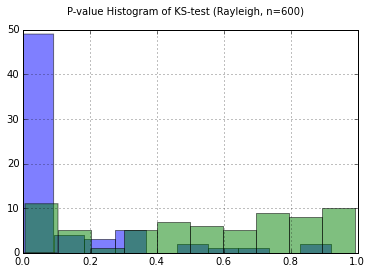

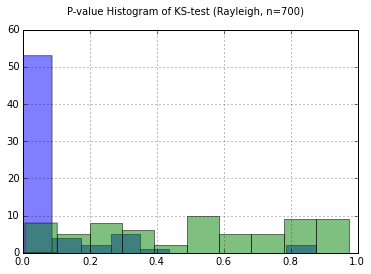

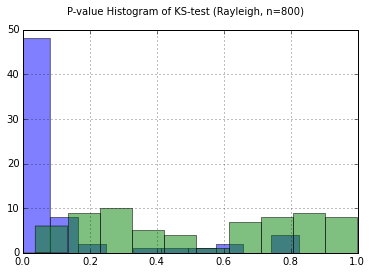

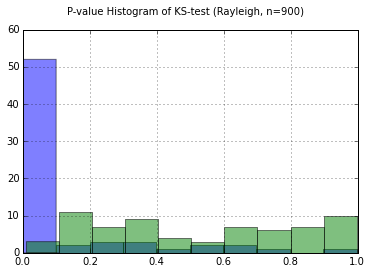

In [201]:
from timeit import timeit

# argument definition
weights_a = w0
weights_b = w1
is_fit = True
n_samp = 100

for num in range(100, 1000, 100):
    #start = timeit()
    
    n_samp = num
    res = hyper_parameter_tester(weights_a, weights_b, is_fit, n_samp)
    title_str = "P-value Histogram of KS-test (Rayleigh, n=%d)" % n_samp
    
    plt.figure()
    res.true_pval.hist(alpha=0.5) 
    res.wrong_pval.hist(alpha=0.5)
    plt.suptitle(title_str)
    plt.show()
    
    #end = timeit()
    #print "Elapsed %.2f" % (end - start)

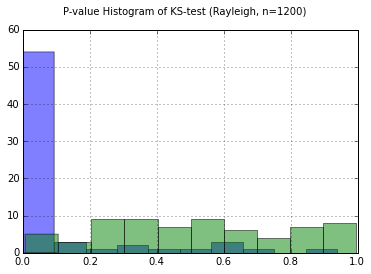

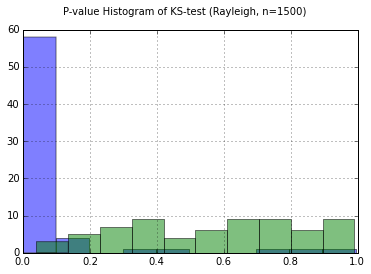

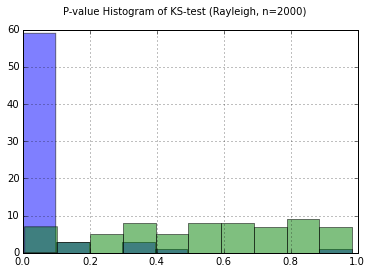

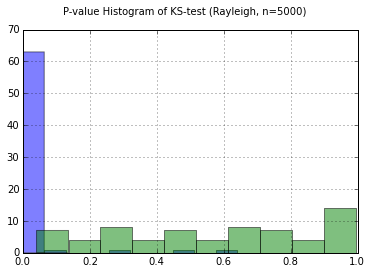

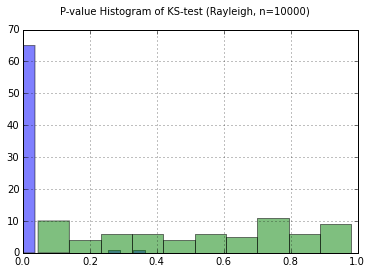

In [202]:
n_samp_range = [1200, 1500, 2000, 5000, 10000]
for num in n_samp_range:
    #start = timeit()
    
    n_samp = num
    res = hyper_parameter_tester(weights_a, weights_b, is_fit, n_samp)
    title_str = "P-value Histogram of KS-test (Rayleigh, n=%d)" % n_samp
    
    plt.figure()
    res.true_pval.hist(alpha=0.5) 
    res.wrong_pval.hist(alpha=0.5)
    plt.suptitle(title_str)
    plt.show()

#### Conclusion 01:
With respects to P-value of KS-test for distances of friends vs. non-friends, the larger size of samples can increase the deterministics of goodness of a weights to a particular user.

#### Test Rayleigh-based KS-test to detection power with varying #sample comparing distance

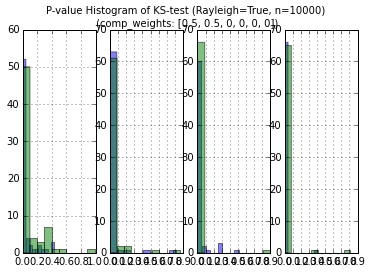

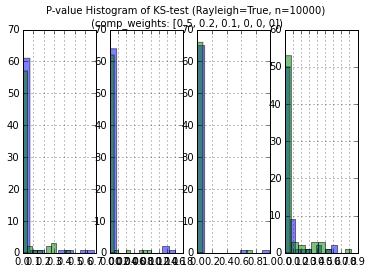

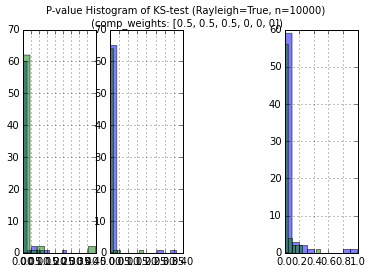

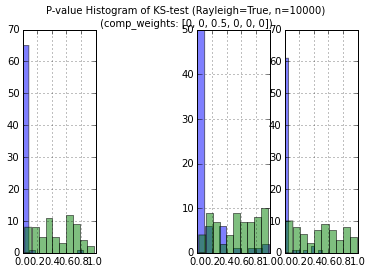

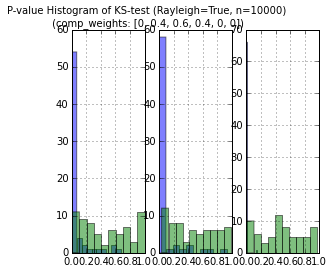

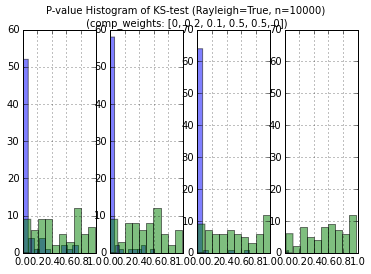

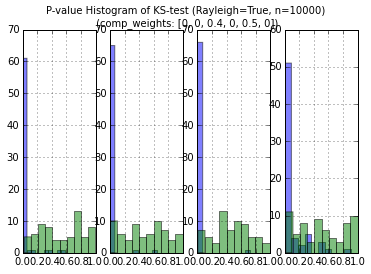

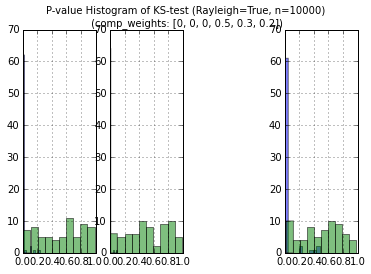

In [213]:
compare_weights = [[0.5, 0.5,   0,   0,   0,   0],
                   [0.5, 0.2, 0.1,   0,   0,   0],
                   [0.5, 0.5, 0.5,   0,   0,   0],
                   [  0,   0, 0.5,   0,   0,   0],
                   [  0, 0.4, 0.6, 0.4,   0,   0],
                   [  0, 0.2, 0.1, 0.5, 0.5,   0],
                   [  0,   0, 0.4,   0, 0.5,   0],
                   [  0,   0,   0, 0.5, 0.3, 0.2]]

n_samp_range = [1000, 2000, 5000, 10000]

_plot_counter = 1
_plot_nrow = len(compare_weights)
_plot_ncol = len(n_samp_range)

for i, c_weights in enumerate(compare_weights):
    
    plt.figure()
    title_str = "P-value Histogram of KS-test (comp_weights: %s)" % (c_weights)
    plt.suptitle(title_str)
    
    for j, n_samp in enumerate(n_samp_range):
                
        res = hyper_parameter_tester(weights_a, c_weights, is_fit, n_samp)
    
        ax = plt.subplot(1, _plot_ncol, _plot_counter)    
        res.true_pval.hist(alpha=0.5) 
        res.wrong_pval.hist(alpha=0.5)
        subtitle_str = "n = %d" % n_samp
        ax.set_title(subtitle_str)
        
        if _plot_counter == 4:
            _plot_counter = 0
        else:
            _plot_counter += 1
        
    plt.show() 

#### ks-test based on obseved data (G0)

In [125]:
num_friends = []
num_nonfriends = []
ks_pvals_right = []
ks_pvals_wrong = []

for uid in tg0_ids: 
    sim_dists, diff_dists = user_grouped_dist(uid, w0, profile_df, fnx)
    pval = user_dist_kstest(sim_dists, diff_dists, fit_rayleigh=False)
    ks_pvals_right.append(pval)
    
    sim_dists, diff_dists = user_grouped_dist(uid, w1, profile_df, fnx)
    pval = user_dist_kstest(sim_dists, diff_dists, fit_rayleigh=False)
    ks_pvals_wrong.append(pval)
    
    num_friends.append(len(sim_dists))
    num_nonfriends.append(len(diff_dists))
    
res_report_g0 = pd.DataFrame({"ID": tg0_ids, "num_friends": num_friends, 
                              "num_nonfriends": num_nonfriends, 
                              "true_pval": ks_pvals_right,
                              "wrong_pval": ks_pvals_wrong})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67bcabf590>]], dtype=object)

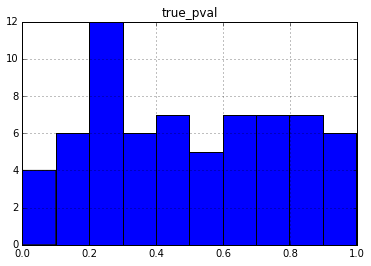

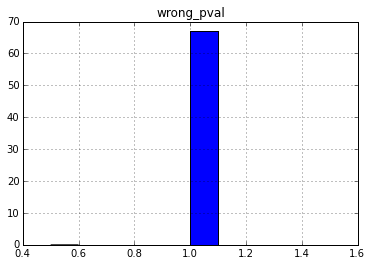

In [126]:
plt.figure(1)
res_report_g0.hist("true_pval")
res_report_g0.hist("wrong_pval")

In [217]:
# learning parameter
RETAIN_TYPE = 0
PVAL = 0.2
MIN_FRIENDS = 10 # not implemented in function
# hyper-parameter
max_iters = 30
mutate_rate = 1
# process controller
counter = 0

# performance collector
num_good_fits = []
num_bad_fits = []
g0_dist_weights = []
g1_dist_weights = []
g0_size = []
g1_size = []

# -------- Initial Weights Leanring ----------- #
ldm = LDM()
ldm.fit(profile_df, friends_df.pair.as_matrix())
the_dist_weights = ldm.get_transform_matrix()

g0, g1 = users_filter_by_weights(weights=the_dist_weights, 
                                 profile_df=profile_df, 
                                 friends_networkx=friends_nx, 
                                 pval_threshold=PVAL, 
                                 mutate_rate=0.5, 
                                 min_friend_cnt=10, 
                                 users_list=all_users_ids)
print "# of memebers in group 0: %d, # of memebers in group 1: %d" % (len(g0), len(g1))

# -------- Individual Group Learning ----------- #
while counter < max_iters:
    counter += 1
    #mutate_rate = min(mutate_rate + 0.05, 1)
    print "------- %d iteration --------" % counter
    g0_dist = ldm_train_with_list(g0, profile_df, friends_df, retain_type=RETAIN_TYPE)
    g1_dist = ldm_train_with_list(g1, profile_df, friends_df, retain_type=RETAIN_TYPE)
    print "Group 0's learned distance metrics:"
    print g0_dist
    print "Group 1's learned distance metrics:"
    print g1_dist

    print "---------------------------------------------- "
    g0_good, g0_bad = users_filter_by_weights(weights=g0_dist, profile_df=profile_df, friends_networkx=friends_nx, 
                                              pval_threshold=PVAL, mutate_rate=0.2, min_friend_cnt=10, 
                                              users_list=g0, fit_rayleigh=True, _n=5000)
    print "# of good fits: %d, # of bad fits: %d" % (len(g0_good), len(g0_bad))
    g1_good, g1_bad = users_filter_by_weights(weights=g1_dist, profile_df=profile_df, friends_networkx=friends_nx, 
                                              pval_threshold=PVAL, mutate_rate=0.2, min_friend_cnt=10, 
                                              users_list=g1, fit_rayleigh=True, _n=5000)
    print "# of good fits: %d, # of bad fits: %d" % (len(g1_good), len(g1_bad))

    print "---------------------------------------------- "
    g0 = g0_good + g1_bad
    g1 = g0_bad + g1_good
    print "# of memebers in group 0: %d, # of memebers in group 1: %d" % (len(g0), len(g1)) 
    print "*********************************************** \n"
    
    g0_dist_weights.append(g0_dist)
    g1_dist_weights.append(g1_dist)
    num_good_fits.append(len(g0_good) + len(g1_good))
    num_bad_fits.append(len(g0_bad) + len(g1_bad))
    g0_size.append(len(g0))
    g1_size.append(len(g1))

--- 342.238224983 seconds ---
# of memebers in group 0: 50, # of memebers in group 1: 50
------- 1 iteration --------
--- 70.8930220604 seconds ---
--- 56.9904811382 seconds ---
Group 0's learned distance metrics:
[0.0, 0.35, 0.64, 0.0, 0.0, 0.0, 0.0]
Group 1's learned distance metrics:
[0.0, 0.38, 0.58, 0.0, 0.04, 0.0, 0.0]
---------------------------------------------- 
# of good fits: 42, # of bad fits: 8
# of good fits: 42, # of bad fits: 8
---------------------------------------------- 
# of memebers in group 0: 50, # of memebers in group 1: 50
*********************************************** 

------- 2 iteration --------
--- 91.0171349049 seconds ---
--- 67.4895780087 seconds ---
Group 0's learned distance metrics:
[0.0, 0.37, 0.62, 0.0, 0.0, 0.0, 0.0]
Group 1's learned distance metrics:
[0.0, 0.37, 0.61, 0.0, 0.01, 0.0, 0.0]
---------------------------------------------- 
# of good fits: 42, # of bad fits: 8
# of good fits: 43, # of bad fits: 7
----------------------------------

#### Experiment with Learning Strategy, 3 containers
* a. container a, store the users expalined well by the distance weights a
* b. container b, store the users expalined well by the distance weights b
* c. container c, buffer container, store the users which were not explained well by neither **distance weights a** nor **distance weights b**. A user rejected by a distance weight will be re-examined with the counterpart distance weights before being sending to the buffer container. The user in this continer will be re-evaluated whenever the distance weights having been updated.


In [254]:
def group_composite(user_id, users_df):
    """ Summarize the emember's belongings
    """
    if len(user_id) > 0:
        is_row = [i_id in user_id for i_id in users_df.ID]
        num_g0 = sum(users_df.ix[is_row, "decision_style"] == 0)
        num_g1 = sum(users_df.ix[is_row, "decision_style"] == 1)
        ptg_g0 = round(num_g0 / float(len(user_id)), 2)
        ptg_g1 = round(num_g1 / float(len(user_id)), 2)
    else: 
        ptg_g0, ptg_g1 = 0, 0
    return (ptg_g0, ptg_g1)

In [ ]:
# ------ argument definition ---- #
PVAL = 0.2
# retain type
retain_type = True
# the percentage of entity whose p-value is
# too large would be returned in res[1] 
mutate_rate = 1 
# True, use rayleigh distribution in KS-test
is_distr_fit = True
# the number of sample withdrawn from the fitted
# rayleigh distribution for KS-test
samp_num = 10000
# stop condition
max_iter= 30

# --- algorithm monitor ------
timer = []
loop_indexes = []
weights_a_collector = []
weights_b_collector = []
cnr_a_size = []
cnr_b_size = []
cnr_c_size = []

# ------ initiation ----- #
np.random.seed(1234)

cnr_a = []
cnr_b = []
cnr_c = []


timer.append(time.time())
# ------ step 01 ------------ #
# training the initial distance weights by learning through the
# complete user base.
print "* ------ initial learning -------- *"
all_user_ids = list(set(users_df.ID))
init_weights = ldm_train_with_list(all_user_ids, profile_df, friends_df, 
                                   retain_type)
print "initial weights: %s" % init_weights
timer.append(time.time())

# ----- step 02 ------------ #
# evalute each user with learned distance weights from
# previous step. Based on pvalue of ks-test, users with
# non-significant evidance for null hypothesis will be
# put in container b (not expalined by the distance wei
# -ghts. The null hypothesis stated that the disttribut
# -ion of between-friends distance is no different than 
# the couterpart of between-non-friends distance. Provi
# -ded with sizable p-value, a user's decision could no
# -t be expalined by the given distance weights
cnr_a, cnr_b = users_filter_by_weights(weights=init_weights, 
                                       profile_df=profile_df, 
                                       friends_networkx=friends_nx, 
                                       pval_threshold=0.5, 
                                       mutate_rate=mutate_rate, 
                                       min_friend_cnt=10, 
                                       users_list=all_users_ids,
                                       fit_rayleigh=is_distr_fit, _n=samp_num)

print "Group a's #member: %d" % len(cnr_a)
print "Group b's #member: %d" % len(cnr_b)
timer.append(time.time())

# ---- step 03 ----------- #
# learn a distinct set of distance weights for each
# of two user groups. Subsequently, using the newly
# learned distance weights to examine the members of 
# corresponding user group to determine if each mem
# -ber should be retined in the group, or not. The
# user rejected from its original group is subject
# to examination of the couterparting distance weights
# to see if it is good to be kept in the couterparting
# user group (or container). The users being rejected
# by both of distance weights will be stored in the 
# container c.
counter = 0
is_continue = True 
while is_continue:
    
    loop_disp_idx = counter + 1
    print "******** %d round ***********" % loop_disp_idx
    print "weights a is in learning..."
    weights_a = ldm_train_with_list(cnr_a, profile_df, friends_df, retain_type)
    
    print "weights b is in learning..."
    weights_b = ldm_train_with_list(cnr_b, profile_df, friends_df, retain_type)
    
    print "Group a's distance weights: %s" % weights_a
    print "Group b's distance weights: %s" % weights_b
    
    # examine the users in group a if it is suitable for weights_a
    # the reject group will be examined by weights_b
    # to see if some of them can be assigned to group b
    cnr_a, rej_a = users_filter_by_weights(weights=weights_a, 
                                           profile_df=profile_df, 
                                           friends_networkx=friends_nx, 
                                           pval_threshold=PVAL, mutate_rate=mutate_rate, min_friend_cnt=10, 
                                           users_list=cnr_a,
                                           fit_rayleigh=is_distr_fit, _n=samp_num)
    
    # examine the user
    cnr_b, rej_b = users_filter_by_weights(weights=weights_b, 
                                           profile_df=profile_df, 
                                           friends_networkx=friends_nx, 
                                           pval_threshold=PVAL, mutate_rate=mutate_rate, min_friend_cnt=10, 
                                           users_list=cnr_b,
                                           fit_rayleigh=is_distr_fit, _n=samp_num)

    add_b, add_c1 = users_filter_by_weights(weights=weights_b, 
                                            profile_df=profile_df, 
                                            friends_networkx=friends_nx, 
                                            pval_threshold=PVAL, mutate_rate=mutate_rate, min_friend_cnt=10, 
                                            users_list=rej_a,
                                            fit_rayleigh=is_distr_fit, _n=samp_num)
    
    add_a, add_c2 = users_filter_by_weights(weights=weights_a, 
                                            profile_df=profile_df, 
                                            friends_networkx=friends_nx, 
                                            pval_threshold=PVAL, mutate_rate=mutate_rate, min_friend_cnt=10, 
                                            users_list=rej_b,
                                            fit_rayleigh=is_distr_fit, _n=samp_num)
    
    if len(cnr_c) > 0:
        # examine the users in cnr_c of previous version with weights_a
        # which is learned within this loop to see if they can be added
        # to cnr_a
        add_a_from_c, cnr_c = users_filter_by_weights(weights=weights_a, 
                                                      profile_df=profile_df, 
                                                      friends_networkx=friends_nx, 
                                                      pval_threshold=PVAL, mutate_rate=mutate_rate, 
                                                      min_friend_cnt=10, 
                                                      users_list=cnr_c,
                                                      fit_rayleigh=is_distr_fit, _n=samp_num)
        cnr_a = cnr_a + add_a_from_c
        
        if len(cnr_c) > 0:
            # examine remaining users in cnr_c with weights b
            add_b_from_c, cnr_c = users_filter_by_weights(weights=weights_b, 
                                                          profile_df=profile_df, 
                                                          friends_networkx=friends_nx, 
                                                          pval_threshold=PVAL, mutate_rate=mutate_rate, 
                                                          min_friend_cnt=10, 
                                                          users_list=cnr_c,
                                                          fit_rayleigh=is_distr_fit, _n=samp_num)
            cnr_b = cnr_b + add_b_from_c        
    
    # consolidate memebers/users
    cnr_a = cnr_a + add_a
    cnr_b = cnr_b + add_b
    cnr_c = cnr_c + add_c1 + add_c2
    
    print "Group a's #member: %d" % len(cnr_a)
    print "Container A's composition: (0: %.2f, 1: %.2f)" % group_composite(cnr_a, users_df)
    print "Group b's #member: %d" % len(cnr_b)
    print "Container B's composition: (0: %.2f, 1: %.2f)" % group_composite(cnr_b, users_df)
    print "Group c's #member: %d" % len(cnr_c)
    print "Container C's composition: (0: %.2f, 1: %.2f)" % group_composite(cnr_c, users_df)
    
    loop_indexes.append(counter)
    weights_a_collector.append(weights_a)
    weights_b_collector.append(weights_b)
    cnr_a_size.append(len(cnr_a))
    cnr_b_size.append(len(cnr_b))
    cnr_c_size.append(len(cnr_c))
    
    timer.append(time.time())
    
    counter += 1
    
    if counter >= max_iter:
        is_continue = False

del rej_a, rej_b, add_c1, add_c2, add_a_from_c, add_b_from_c

perf_report = pd.DataFrame({"loop_index": loop_indexes,
                            "group_a_size": cnr_a_size,
                            "group_b_size": cnr_b_size,
                            "group_c_size": cnr_c_size})

# timer
# weights_a_collector
# weights_b_collector

* ------ initial learning -------- *
--- 68.3240339756 seconds ---
initial weights: [0.0, 0.39, 0.61, 0.0, 0.0, 0.0, 0.0]
Group a's #member: 42
Group b's #member: 58
******** 1 round ***********
weights a is in learning...
--- 52.0605630875 seconds ---
weights b is in learning...
--- 41.0844769478 seconds ---
Group a's distance weights: [0.02, 0.58, 0.34, 0.06, 0.0, 0.0, 0.0]
Group b's distance weights: [0.0, 0.1, 0.64, 0.0, 0.26, 0.0, 0.0]
Group a's #member: 89